In [1]:
import matplotlib.pyplot as plt
from einops import rearrange

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader


import monai
from monai.transforms import LoadImage
from monai.config import print_config

from scripts.train import LitUnet
import pytorch_lightning as pl

from scripts.utils import *
from scripts.data import *

#print_config()

/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_directory = "Data/M&Ms/OpenDataset"
transform =  monai.transforms.ScaleIntensity(minv=0.0, maxv=1.0)

*centre_data, _ = get_centre_2D_dataset(6, root_directory, transform=transform)
train_dataset = Centre2DDataset(centre_data)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)


*centre_data, _ = get_centre_2D_dataset(1, root_directory, transform=transform)
val_dataset = Centre2DDataset(centre_data)
val_loader = DataLoader(val_dataset, batch_size=8, num_workers=4)


Loading Files from Data/M&Ms/OpenDataset


76it [00:02, 25.87it/s]


Loading Files from Data/M&Ms/OpenDataset


19it [00:00, 27.26it/s]


In [3]:
model = LitUnet(lr=1e-4)

# Training and Validation
trainer = pl.Trainer(max_epochs=30, deterministic=True, log_every_n_steps=2)
trainer.fit(model, train_loader, val_loader)

/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-pac ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-pac ...
  rank_zero_warn(
/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/pytorch_lightning/ca

Epoch 29: 100%|██████████| 222/222 [00:06<00:00, 34.01it/s, v_num=37918]   

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 222/222 [00:06<00:00, 33.60it/s, v_num=37918]


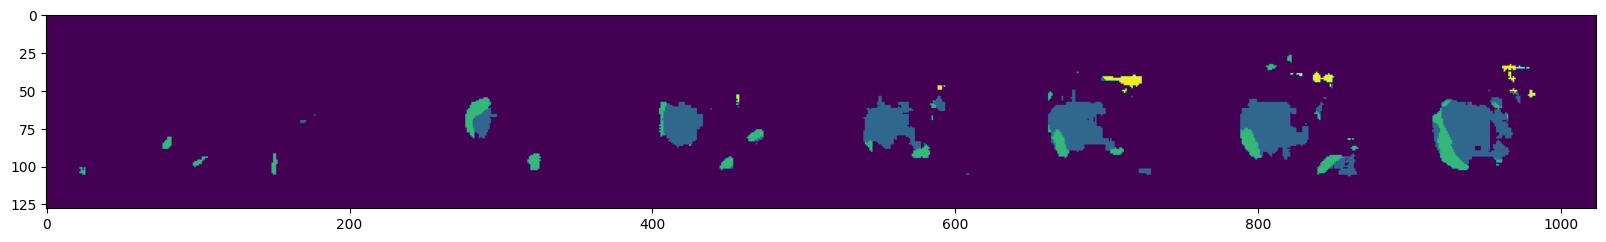

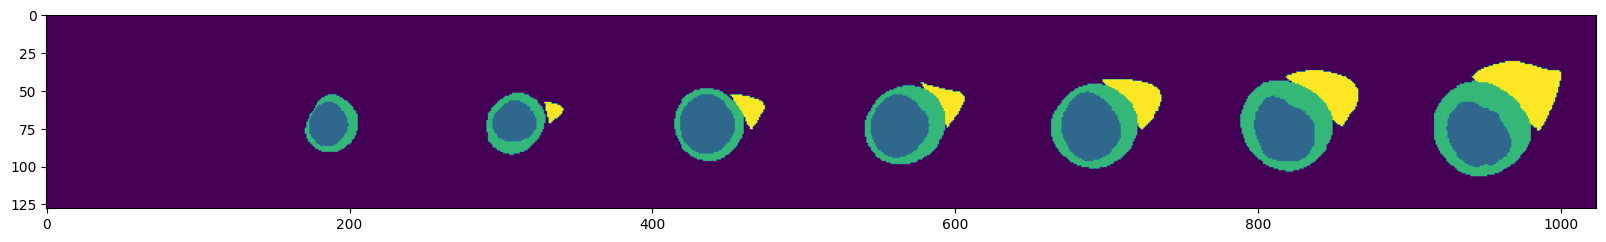

In [5]:
model = LitUnet.load_from_checkpoint("lightning_logs/version_37918/checkpoints/epoch=29-step=6660-v1.ckpt")
model.eval()

batch = next(iter(val_loader))
x, y = batch

device = torch.device('cuda:0')
x = x.to(device)


pred = model(x)
prob = F.softmax(pred, dim=1)
y_pred = torch.argmax(prob, dim=1).cpu()

n = 20
plt.figure(figsize=(n, 5))
plt.imshow(rearrange(y_pred[:n+1], "b h w -> h (b w)"))
plt.show()
plt.figure(figsize=(n, 5))
plt.imshow(rearrange(y[:n+1], "b h w -> h (b w)"))
plt.show()

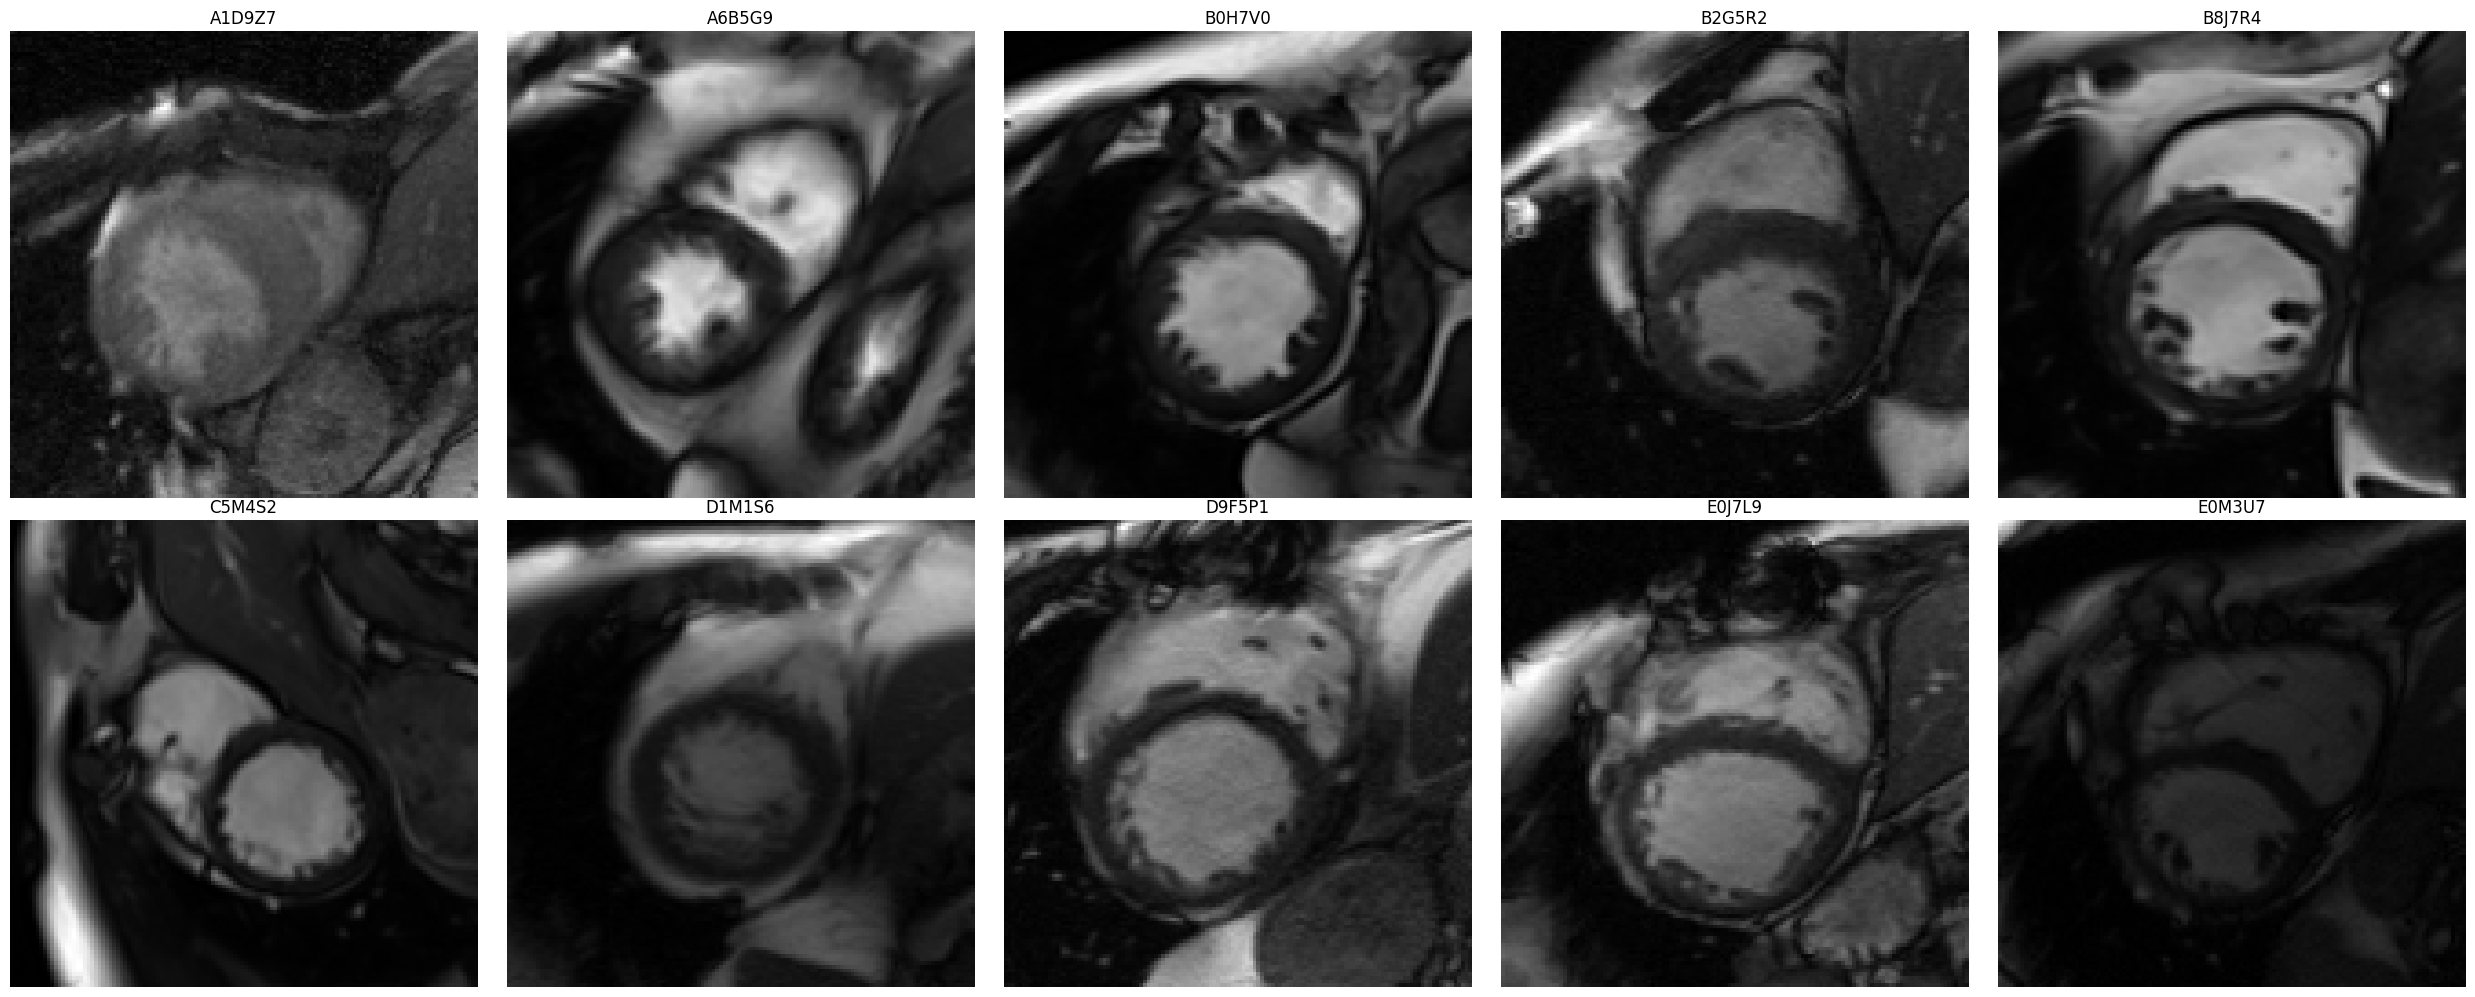

In [3]:
root_directory = "Data/M&Ms/OpenDataset"
centre = 1
subject_ids, subject_images, subject_labels = get_subjects_files_paths(root_directory, centre=centre)
n = 10
fig, axes = plt.subplots(n//5, 5, figsize=(25, n))

for i in range(n):
    data = LoadImage(image_only=True, ensure_channel_first=True)(subject_images[i])

    # Display all available channels of the image
    ax = axes[i // 5, i % 5]
    ax.imshow(data[0, :, :, 5], cmap='gray')
    ax.set_title(f"{subject_ids[i]}")
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

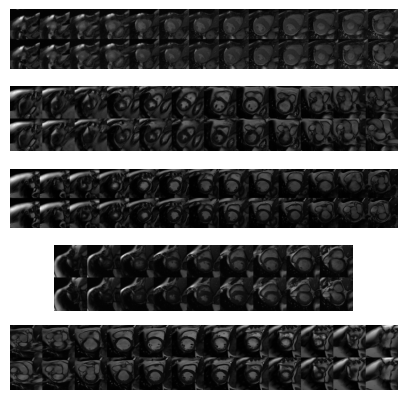

In [9]:
n = 5
fig, axes = plt.subplots(n, figsize=(5, n))
for i in range(n):
    axes[i].imshow(rearrange(images[i], '(c1 c2) 1 h w -> (c1 h) (c2 w) 1', c1=2), "gray")
    axes[i].axis('off')
plt.show()